Author: Nikko V. salcedo
This is a classification model development using keras and tensorflow to detect hurricane damage using satellite images.  

Available dataset:  
Training - 10,0000  
Validation - 2,000  
Test - 9,000  

# Part 1. Import all needed packages

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import seaborn as sns
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import random
import matplotlib.pyplot as plt
sns.set()

# Part 2. Pre-procesing

In [2]:
# Dataset Image paths
TEST_LOC= "../../datasets/sat_images/test_another"
TRAIN_LOC = "../../datasets/sat_images/train_another"
VAL_LOC = "../../datasets/sat_images/validation_another"

#Other global variables:
IMG_SIZE = (128,128)
BATCH_SIZE = 150
classes = {'no_damage':0, 'damage': 1,}

#Image Data Generator Objects

""" 
Augmentations done on trianing data:
1. rotation
2. zoom
3. reflect
4. vertical flip
5. horizontal flip
6. rescale

This is to avoid overfitting
"""
train_idg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    zoom_range=0.5,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0/255
)

test_idg =tf.keras.preprocessing.image.ImageDataGenerator( rescale=1.0/255)

#creating the datasets

train_gen = train_idg.flow_from_directory(TRAIN_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=BATCH_SIZE
                                         )

val_gen = train_idg.flow_from_directory(VAL_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=BATCH_SIZE
                                         )
test_gen = test_idg.flow_from_directory(TEST_LOC, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb', shuffle=False,
                                         batch_size=1
                                         )


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


### Some functions for unpacking and viewing the data

In [3]:
def view_generator_data(gen, n):
    data = [next(gen) for _ in range(n)]
    data = list(zip(*data))
    X, y = data
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def view_images(X, y, n=None):
    n = n or len(X)
    for i in range(n):
        plt.imshow(X[i])
        plt.grid(None)
        plt.show()
        print('Label: ', y[i])
test_gen.__len__()

9000

## Loading sample images for "damaged" class

From test dataset


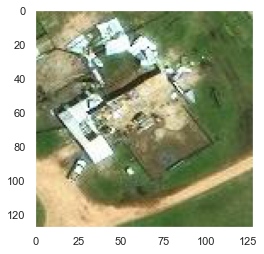

Label:  1.0

From Training dataset


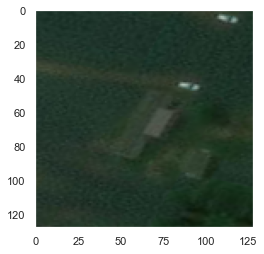

Label:  1.0

From validation dataset


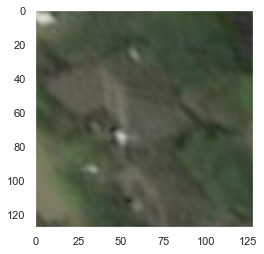

Label:  1.0


In [4]:
print("From test dataset")
(X,y) = test_gen.__getitem__(8996)
view_images(X,y)

print("\nFrom Training dataset")
(X,y) = train_gen.__getitem__(35)
view_images(X,y,1)

print("\nFrom validation dataset")
(X,y) = val_gen.__getitem__(11)
view_images(X,y,1)

## Loading samples of "no damage" class images

From test dataset


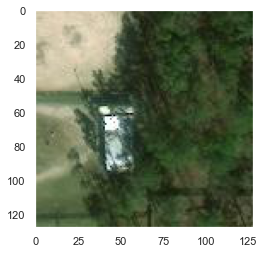

Label:  0.0

From Training dataset


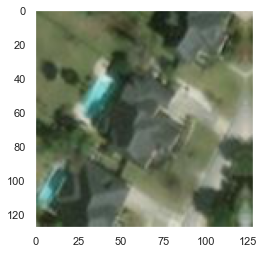

Label:  0.0

From validation dataset


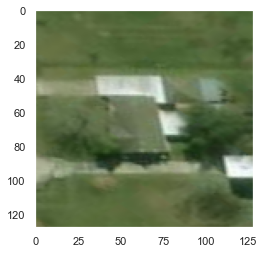

Label:  0.0


In [5]:
print("From test dataset")
(X,y) = test_gen.__getitem__(6)
view_images(X,y)

print("\nFrom Training dataset")
(X,y) = train_gen.__getitem__(5)
view_images(X,y,1)

print("\nFrom validation dataset")
(X,y) = val_gen.__getitem__(2)
view_images(X,y,1)

# Part 3. Defining the model architecture

3.a. Defining some variables

In [4]:
# Locations for saving models
MODEL_DIR = 'project_models/checkpoints6/model_at_{epoch:02d}.ckpt'
BEST_DIR = 'project_models/checkpoints6/best/best_model.ckpt'
os.makedirs(os.path.dirname(MODEL_DIR), exist_ok=True)
os.makedirs(os.path.dirname(BEST_DIR), exist_ok=True)

#loss function
loss = tf.keras.losses.BinaryCrossentropy()

#optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

#metrics
metrics = [tf.keras.metrics.BinaryAccuracy(threshold = 0.6)]

#callbacks
early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_DIR)
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_DIR, save_best_only=True)

3.b. Model architecture

In [7]:
img_input = tf.keras.layers.Input((128,128,3))
base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet',
                                        input_tensor = img_input)
X = base_model.output
#Lock weights value
base_model.trainable = False

#Flatten
fl1 = tf.keras.layers.Flatten()(X)
dense1 = tf.keras.layers.Dense(100,activation='relu')(fl1)
output = tf.keras.layers.Dense(1,activation='sigmoid')(dense1)

#model creation
model = tf.keras.Model(inputs=img_input, outputs=output)
model.compile( optimizer=opt,loss=loss, metrics=metrics )

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

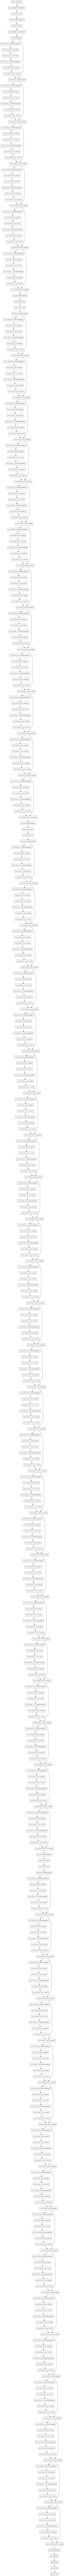

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
history = model.fit ( 
        train_gen,
        epochs =50,
        callbacks=[early_stop, model_checkpoint, best_checkpoint],
        validation_data = val_gen
                      )

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.7929 - binary_accuracy: 0.6308WARNING:tensorflow:From D:\Programs\Anaconda\envs\tf-gpu-py37\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: project_models/checkpoints6/model_at_01.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints6/best/best_model.ckpt\assets
67/67 [==============================] - 112s 2s/step - loss: 0.7929 - binary_accuracy: 0.6308 - val_loss: 0.5671 - val_binary_accuracy: 0.7295
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.5277 - binary_accuracy: 0.7445INFO:tensorflow:Assets written to: project_models/checkpoints6/model_at_02.ckpt\assets
INFO:tensorflow:A

Epoch 22/50
67/67 [==============================] - 92s 1s/step - loss: 0.2989 - binary_accuracy: 0.8698 - val_loss: 0.2683 - val_binary_accuracy: 0.8850
Epoch 23/50
67/67 [==============================] - 90s 1s/step - loss: 0.3091 - binary_accuracy: 0.8580 - val_loss: 0.2787 - val_binary_accuracy: 0.8945
Epoch 24/50
67/67 [==============================] - ETA: 0s - loss: 0.2941 - binary_accuracy: 0.8725INFO:tensorflow:Assets written to: project_models/checkpoints6/model_at_24.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints6/best/best_model.ckpt\assets
67/67 [==============================] - 125s 2s/step - loss: 0.2941 - binary_accuracy: 0.8725 - val_loss: 0.2596 - val_binary_accuracy: 0.9075
Epoch 25/50
67/67 [==============================] - 92s 1s/step - loss: 0.2938 - binary_accuracy: 0.8665 - val_loss: 0.2618 - val_binary_accuracy: 0.8900
Epoch 26/50
67/67 [==============================] - 90s 1s/step - loss: 0.3101 - binary_accuracy: 0.8634 - val_

Epoch 45/50
67/67 [==============================] - 96s 1s/step - loss: 0.2427 - binary_accuracy: 0.9021 - val_loss: 0.2716 - val_binary_accuracy: 0.8675
Epoch 46/50
67/67 [==============================] - ETA: 0s - loss: 0.2690 - binary_accuracy: 0.8768INFO:tensorflow:Assets written to: project_models/checkpoints6/model_at_46.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints6/best/best_model.ckpt\assets
67/67 [==============================] - 140s 2s/step - loss: 0.2690 - binary_accuracy: 0.8768 - val_loss: 0.2193 - val_binary_accuracy: 0.9125
Epoch 47/50
67/67 [==============================] - ETA: 0s - loss: 0.2525 - binary_accuracy: 0.8922INFO:tensorflow:Assets written to: project_models/checkpoints6/model_at_47.ckpt\assets
INFO:tensorflow:Assets written to: project_models/checkpoints6/best/best_model.ckpt\assets
67/67 [==============================] - 131s 2s/step - loss: 0.2525 - binary_accuracy: 0.8922 - val_loss: 0.2070 - val_binary_accuracy: 0.9100

# Part 3. Visualizing Results

3.a. Charts for training and validation metrics

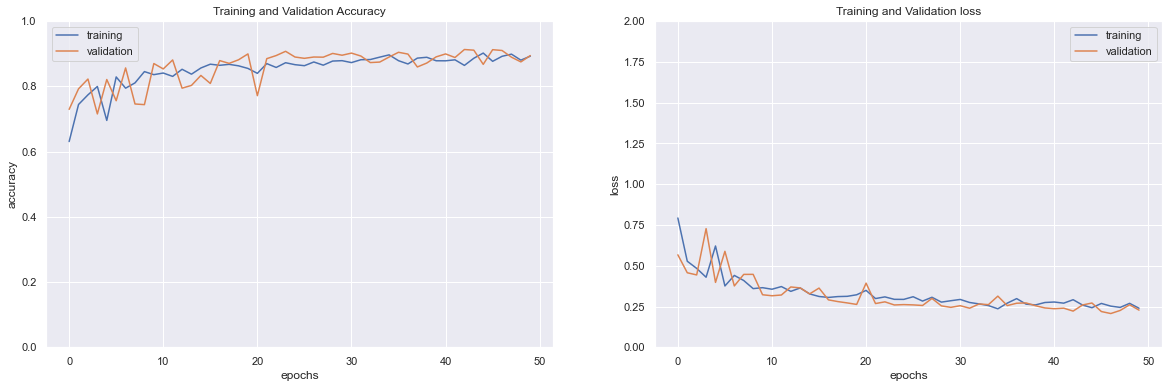

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

axes[0].plot(history.history[('binary_accuracy')])
axes[0].plot(history.history[('val_binary_accuracy')])
axes[0].legend(['training', 'validation'])
axes[0].set_title("Training and Validation Accuracy")
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].set_ylim([0,1])

axes[1].plot(history.history[('loss')])
axes[1].plot(history.history[('val_loss')])
axes[1].legend(['training', 'validation'])
axes[1].set_title("Training and Validation loss")
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].set_ylim([0,2])



plt.show()

3.b. Loading the Best Model

In [5]:
best_model = tf.keras.models.load_model(BEST_DIR)


3.c. Loading a test dataset with 2000 items

In [6]:
TEST_LOC_LIGHT= "../../datasets/sat_images/test"

test_idg_light = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_gen_light = test_idg_light.flow_from_directory(TEST_LOC_LIGHT, IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb',   shuffle=False,
                                         batch_size=1
                                        )

Found 2000 images belonging to 2 classes.


In [7]:
test_X, test_y = view_generator_data(test_gen_light, test_gen_light.n)

3.d. Predictions from test data

In [8]:
y_pred = best_model.predict(test_X)
y_pred.reshape(2000,)

array([0.05981935, 0.07158179, 0.10302784, ..., 0.77756214, 0.45931482,
       0.49559692], dtype=float32)

In [9]:
roc_auc_score(test_y, y_pred)

0.9759479999999999

### 3.e. Metrics
PRECISION - RECALL CURVE

In [10]:
pr, r, thr = precision_recall_curve(test_y, y_pred)

ROC CURVE

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, thres = roc_curve(test_y, y_pred, pos_label=1)

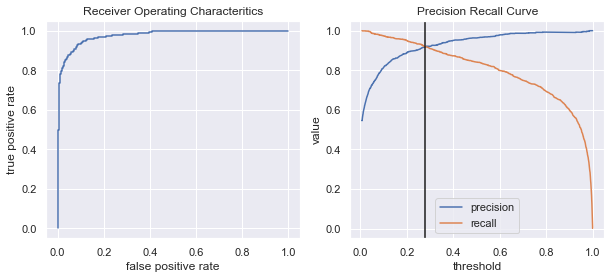

In [14]:
fig,ax = plt.subplots(figsize=(10,4), ncols=2)

ax[0].plot( fpr,tpr)
ax[0].set_title("Receiver Operating Characteritics")
ax[0].set_xlabel("false positive rate")
ax[0].set_ylabel("true positive rate")


ax[1].plot(thr, pr[:-1])
ax[1].plot(thr, r[:-1])
ax[1].set_xlabel('threshold')
ax[1].set_ylabel('value')
plt.axvline(x=0.28, color='k')
ax[1].legend(["precision", 'recall'])
ax[1].set_title("Precision Recall Curve")
plt.show()

In [15]:
threshold = 0.28
accuracy_score(test_y > threshold, y_pred > threshold)

0.9185

CLASSIFICATION REPORT

              precision    recall  f1-score   support

       False       0.92      0.92      0.92      1000
        True       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



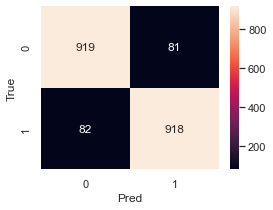

In [16]:
print(classification_report(test_y>threshold, y_pred > threshold))
cm = confusion_matrix(test_y>threshold, y_pred > threshold)
plt.figure( figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="g")
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()